# Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp

# Load data

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
s = [x for x in acidoCEST_ML.shape]
print( f'data size | rows = {s[0]:,}, cols = {s[1]:,}' )

data size | rows = 20,000, cols = 88


In [5]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample(frac=.10)

# Logistic Regression

In [6]:
# Logistic Regression
from sklearn.metrics import confusion_matrix, classification_report

def classification_metrics(Yexpected, Yhat):
    cm = confusion_matrix(Yexpected, Yhat)
    TN, FP, FN, TP = list(cm.flatten())
    
    metrics = dict (  PPV =  TP / (TP + FP) 
                 , NPV = TN / (TN + FN)
                 , SEN = TP / (TP + FN)
                 , SPC = TN / (TN + FP)
               )
    for m in metrics.keys():
        metrics[m] = np.round(metrics[m],3)
    
    return metrics

def train_logistic_reg(Xdata, pH_observed, pH_cut_off = 7.0, n_cs = 20, maxC = 1):
    
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Xdata.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='saga', penalty='l1', max_iter=10_000,random_state=42, n_jobs=-1)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('logistic', logistic)])


    # Training parameters
    Cs = np.logspace(-3, maxC, n_cs)
    
    param_grid ={
    'logistic__C': Cs,
    'logistic__class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 3, cv = 3, n_jobs= 2, scoring=metrics.make_scorer( metrics.balanced_accuracy_score))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    # CLASSIFC
    classification_per = classification_metrics(y_test, estimator.predict(X_test))
    print('Classification Performance \n')
    [print(f'{key} : {value}') for key, value in classification_per.items()]
    print('---'*10)
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #skplt.metrics.plot_confusion_matrix (y_test, estimator.predict(X_test))
    
    plt.show()
    
    #print( metrics.classification_report(y_test, estimator.predict(X_test)) )
    
    

    return estimator.best_estimator_, X_train, X_test, y_train, y_test

def classify_pH_Log_Reg(X,Y, cut_offs=[6.5,7.0], Ncs= 10):
    # Data Size
    data_size(X)
    
    ## Logistic REgression: Only Zspectra pH = 7.0
    classifiers =dict()
    
    for pH in cut_offs: 
        print('======  pH = {} ====== '.format(pH))
        clf, X_train, X_test, y_train, y_test = train_logistic_reg(X,Y, pH_cut_off = pH, n_cs = Ncs);
        
        classifiers[str(pH)] = clf

    return classifiers

def data_size(DataFrame):
    r, c = DataFrame.shape
    print(f' row = {r:,} | cols = {c:,}')

## Number of Cs for Log. Reg

In [7]:
Ncs = 10

## - 4.2 and 5.6 only

 row = 20,000 | cols = 2
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.811
NPV : 0.383
SEN : 0.506
SPC : 0.721
------------------------------


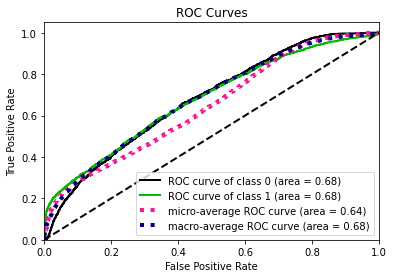

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.487
NPV : 0.843
SEN : 0.548
SPC : 0.808
------------------------------


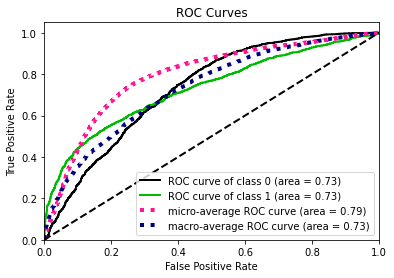

CPU times: user 3.09 s, sys: 615 ms, total: 3.7 s
Wall time: 3.39 s


In [8]:
%%time
Xdata_iso = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH

two_freqs = classify_pH_Log_Reg(Xdata_iso,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

## - 4.2 ppm, 5.6 ppm, exp data

In [9]:
len(['4.2','5.6'] + exper_cols)

8

In [10]:
print(exper_cols)

['ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)', 'SatTime(ms)', 'ExpT1(ms)', 'ExpT2(ms)']


 row = 20,000 | cols = 8
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.854
NPV : 0.458
SEN : 0.624
SPC : 0.749
------------------------------


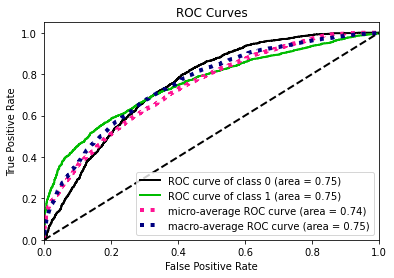

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.485
NPV : 0.868
SEN : 0.648
SPC : 0.77
------------------------------


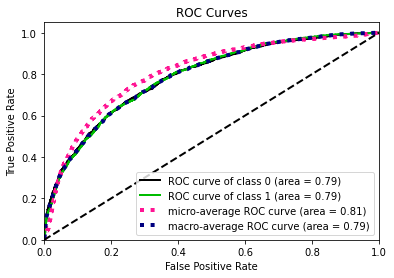

CPU times: user 3.79 s, sys: 640 ms, total: 4.43 s
Wall time: 4.13 s


In [11]:
%%time

c = ['4.2','5.6'] + exper_cols

Xdata_iso_and_exp = acidoCEST_ML[c]
Ydata = acidoCEST_ML['pH'].apply(lambda x: np.round(x,1))

two_freqs_and_exp = classify_pH_Log_Reg(Xdata_iso_and_exp,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

## - Only Zspectra

 row = 20,000 | cols = 81
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.924
NPV : 0.586
SEN : 0.744
SPC : 0.857
------------------------------


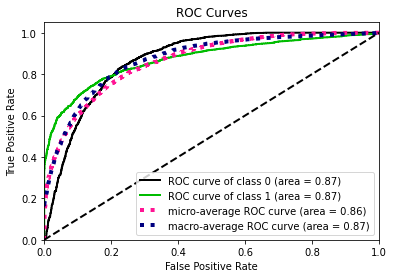

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.57
NPV : 0.919
SEN : 0.787
SPC : 0.802
------------------------------


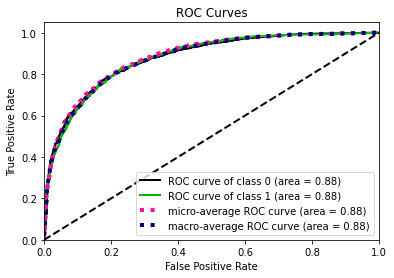

81 frequencies
6 exper cols
CPU times: user 32.3 s, sys: 385 ms, total: 32.7 s
Wall time: 10min 42s


In [12]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

only_zspectra = classify_pH_Log_Reg(Xdata,Ydata, cut_offs=[6.5,7.0], Ncs = Ncs)

print( f'{len(Xdata.columns)} frequencies' )
print( f'{len(exper_cols)} exper cols' )

## -  Zspectra  + exp data

 row = 20,000 | cols = 87
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.932
NPV : 0.591
SEN : 0.744
SPC : 0.873
------------------------------


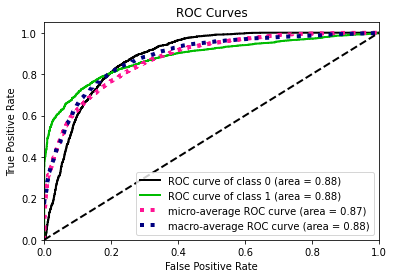

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END logistic__C=0.001, logistic__class_weight=balanced;, score=0.500 total time=   0.0s
[CV 1/3] END logistic__C=0.001, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 3/3] END logistic__C=0.001, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 2/3] END logistic__C=0.0027825594022071257, logistic__class_weight=balanced;, score=0.571 total time=   0.0s
[CV 1/3] END logistic__C=0.0027825594022071257, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 2/3] END logistic__C=0.0027825594022071257, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 1/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.603 total time=   0.0s
[CV 3/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.588 total time=   0.0s
[CV 2/3] END logistic__C=0.007742636826811269, logistic__class_weight=None;,

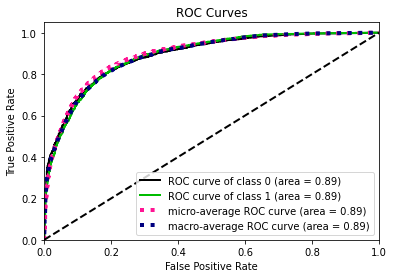

87
CPU times: user 35.6 s, sys: 469 ms, total: 36.1 s
Wall time: 12min 5s


In [13]:
%%time

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

all_data = classify_pH_Log_Reg(Xdata,Ydata, cut_offs=[6.5,7.0], Ncs= Ncs)
print( len( list(Xdata.columns) ) )

## -- Coeff

In [14]:
plt.style.use('tableau-colorblind10')

                   Coeff
ExpT1(ms)       0.418004
ExpT2(ms)       1.649329
ExpB1(percent)  1.017106
ExpB0(Hz)       0.083775
SatPower(uT)    1.925113
SatTime(ms)     1.058012
-12             1.000000


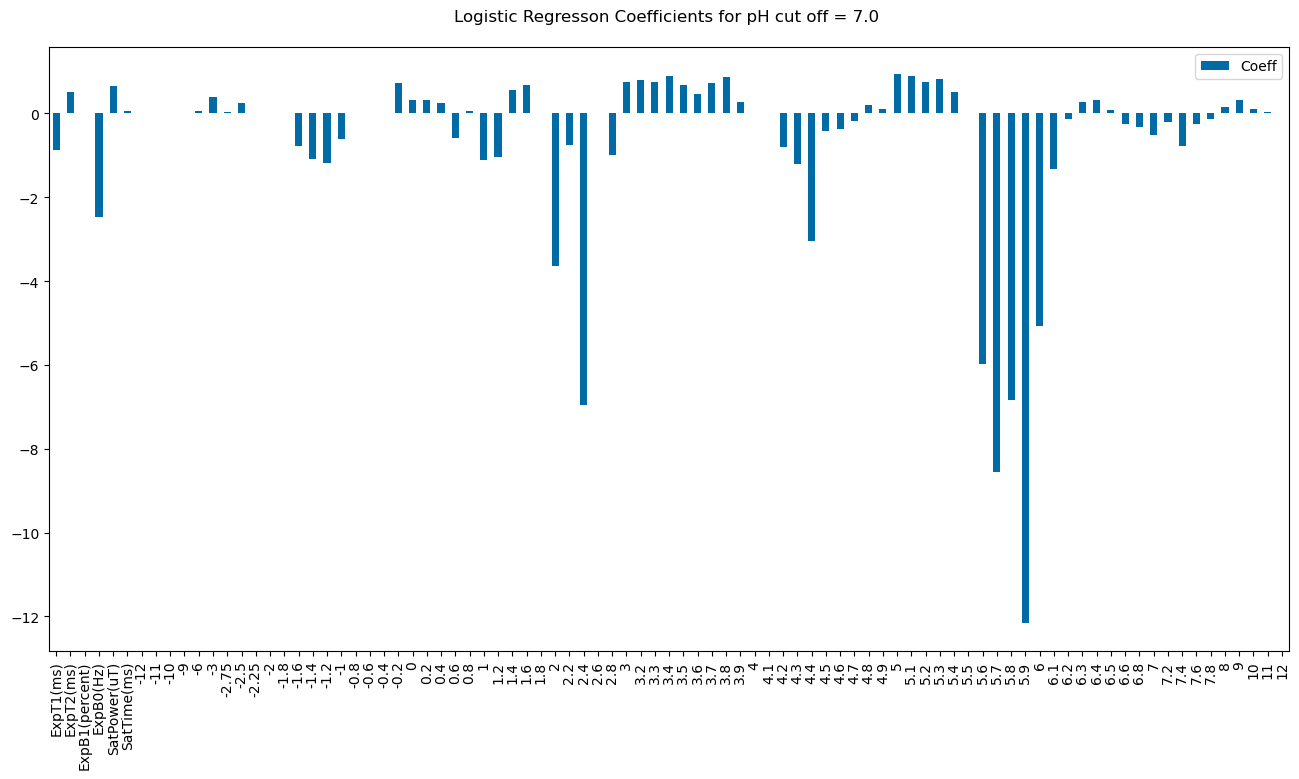

In [15]:
coef = all_data['7.0']['logistic'].coef_

C = pd.DataFrame(1-np.exp(coef.reshape(-1,1)),index=acidoCEST_ML.drop( ['pH'],axis=1).columns, columns=['Coeff' ])
print(np.exp(C.head(7)))
_, ax = plt.subplots(dpi=100, figsize=(16,8))
C.plot(kind='bar',ax=ax,rot=90)
plt.title('Logistic Regresson Coefficients for pH cut off = 7.0 \n')
plt.savefig('../figs/Figure_01_Classification.png',bbox_inches='tight')
plt.show()

                   Coeff
ExpT1(ms)       1.299081
ExpT2(ms)       0.948909
ExpB1(percent)  0.972967
ExpB0(Hz)       0.304494
SatPower(uT)    0.551223
SatTime(ms)     1.099888
-12             0.889371


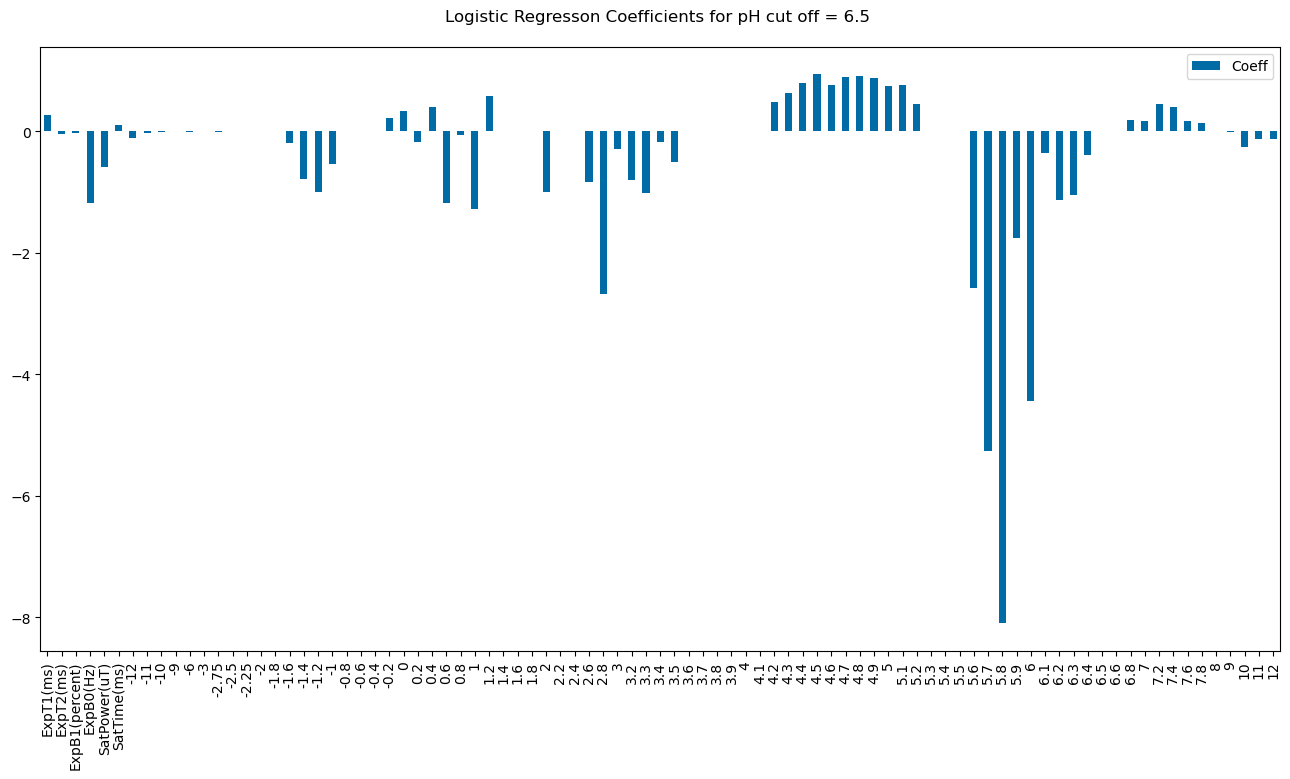

In [16]:
coef = all_data['6.5']['logistic'].coef_

C = pd.DataFrame(1-np.exp(coef.reshape(-1,1)),index=acidoCEST_ML.drop( ['pH'],axis=1).columns, columns=['Coeff' ])
print(np.exp(C.head(7)))
_, ax = plt.subplots(dpi=100, figsize=(16,8))
C.plot(kind='bar',ax=ax,rot=90)
plt.title('Logistic Regresson Coefficients for pH cut off = 6.5 \n')

plt.savefig('../figs/Figure_02_Classification.png',bbox_inches='tight')
plt.show()

## -- Feature Selection and Log Reg on selected features

23
 row = 20,000 | cols = 23
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.904
NPV : 0.565
SEN : 0.733
SPC : 0.816
------------------------------


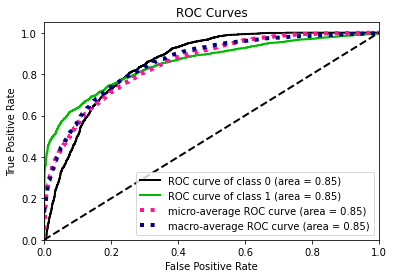

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.521
NPV : 0.911
SEN : 0.777
SPC : 0.762
------------------------------


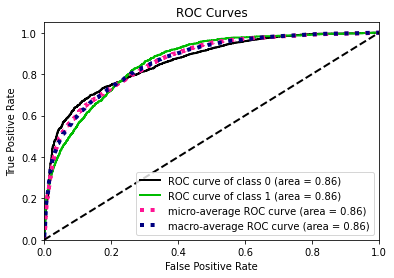

In [17]:
def select_cols(coefficients):
    d = np.exp(coefficients)
    f= (d >1.90) | (d < 0.10)
    cols = np.array(Xdata.columns.values)
    new_cols = cols[f.reshape(-1,)]

    return new_cols
    
coef1 = all_data['7.0']['logistic'].coef_
coef2 = all_data['6.5']['logistic'].coef_

s1 = set(select_cols(coef1))
s2 = select_cols(coef2)

new_cols = list(s1.union(s2))
new_cols.sort()

print(len(new_cols))

Xdata_small = acidoCEST_ML.drop( ['pH'],axis=1)[new_cols]
Ydata = acidoCEST_ML.pH

all_data_small = classify_pH_Log_Reg(Xdata_small,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

In [18]:
print(f'The following features were selected for Logistic Regression: \n {new_cols}')

The following features were selected for Logistic Regression: 
 ['-1.2', '-1.4', '0.6', '1', '1.2', '2', '2.4', '2.8', '3.3', '4.3', '4.4', '4.5', '4.8', '5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2', '6.3', 'ExpB0(Hz)']


In [19]:
# save output
all_data_small_change_in_odds = pd.DataFrame(all_data_small['6.5']['logistic'].coef_.reshape(-1,1),index=new_cols, columns=['6.5'])
all_data_small_change_in_odds['7.0'] = all_data_small['7.0']['logistic'].coef_.reshape(-1,1)
all_data_small_change_in_odds = all_data_small_change_in_odds.applymap(lambda f: np.exp(f) - 1).round(2)
all_data_small_change_in_odds.to_csv('../outputs/classification_change_in_odds_selected.csv')

In [20]:
#  save pipelines
from joblib import dump, load
dump(all_data_small['6.5'], '../models/pH_classication_pipeline_6p5.joblib') 
dump(all_data_small['7.0'], '../models/pH_classication_pipeline_7p0.joblib') 

['../models/pH_classication_pipeline_7p0.joblib']

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier as RFC

def train_RFC(Spectra, pH_observed, pH_cut_off = 7.0):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    rf = RFC(random_state=42, n_jobs=10)
    
    param_grid ={
    'n_estimators': [5,10,20,50,100],
    'max_depth': [2,4,8,10,20] ,
        'class_weight':['balanced',None] ,
        'criterion':['entropy','gini']
    }
    
    estimator = GridSearchCV(rf, param_grid, verbose = 1, cv = 3, n_jobs=6, scoring=metrics.make_scorer( metrics.balanced_accuracy_score))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    
    # CLASSIFC
    classification_per = classification_metrics(y_test, estimator.predict(X_test))
    print('Classification Performance \n')
    [print(f'{key} : {value}') for key, value in classification_per.items()]
    print('---'*10)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)

    plt.show()
    
    return estimator.best_estimator_
    
    

## -- 4.2 and 5.6 only

############ pH = 6.5############
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.804
NPV : 0.392
SEN : 0.549
SPC : 0.685
------------------------------


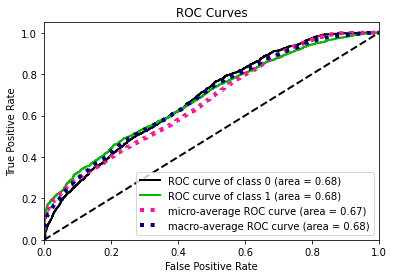

CPU times: user 2.78 s, sys: 246 ms, total: 3.02 s
Wall time: 14 s


<AxesSubplot:>

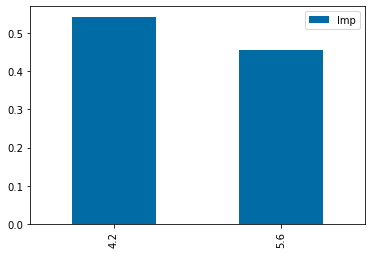

In [23]:
%%time

pH = 6.5

print('==='*20)
print('############ pH = {}############'.format(pH))
Xdata = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH
RF_two_freqs_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

############ pH = 7.0############
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.522
NPV : 0.84
SEN : 0.522
SPC : 0.841
------------------------------


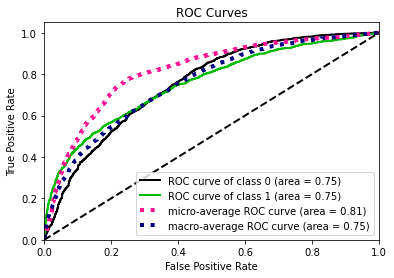

CPU times: user 1.86 s, sys: 155 ms, total: 2.02 s
Wall time: 12.5 s


<AxesSubplot:>

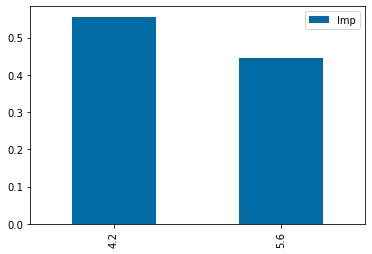

In [24]:
%%time

pH = 7.0

print('==='*20)
print('############ pH = {}############'.format(pH))
Xdata = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH
RF_two_freqs_70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

## -- 4.2 and 5.6  and  non-CEST exp data

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.996
NPV : 0.999
SEN : 1.0
SPC : 0.991
------------------------------


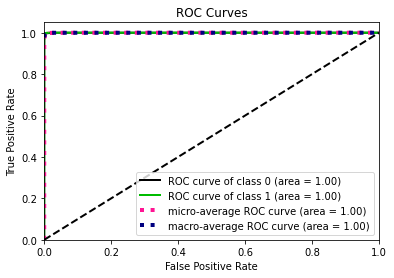

CPU times: user 3.08 s, sys: 188 ms, total: 3.27 s
Wall time: 12.3 s


<AxesSubplot:>

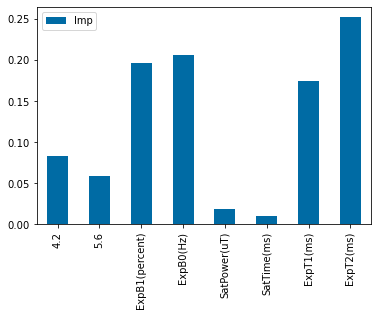

In [25]:
%%time

c = ['4.2','5.6'] + exper_cols
pH = 6.5

Xdata = acidoCEST_ML[c]
Ydata = acidoCEST_ML.pH

RF_two_freqs_and_exp65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_and_exp65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

In [26]:
print(RF_two_freqs_and_exp65)

RandomForestClassifier(criterion='entropy', max_depth=20, n_jobs=10,
                       random_state=42)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 1.0
NPV : 0.996
SEN : 0.988
SPC : 1.0
------------------------------


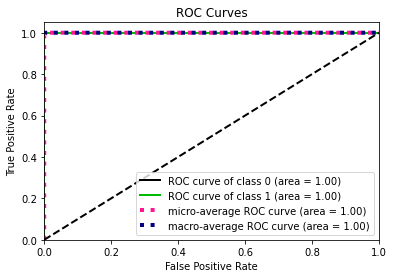

CPU times: user 2.67 s, sys: 182 ms, total: 2.85 s
Wall time: 12.3 s


<AxesSubplot:>

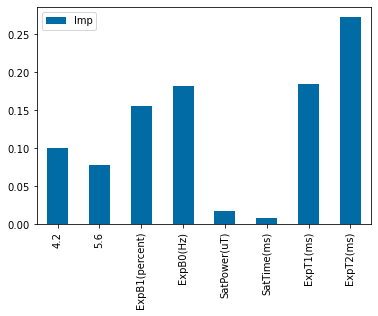

In [27]:
%%time

c = ['4.2','5.6'] + exper_cols
pH = 7.0

Xdata = acidoCEST_ML[c]
Ydata = acidoCEST_ML.pH

RF_two_freqs_and_exp70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_and_exp70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

## -- All sat freqs 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.926
NPV : 0.622
SEN : 0.78
SPC : 0.853
------------------------------


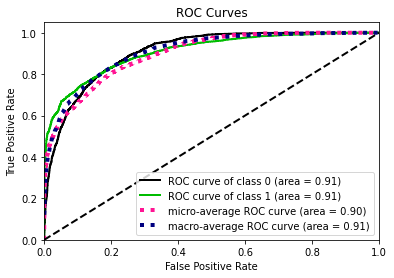

CPU times: user 9.34 s, sys: 182 ms, total: 9.53 s
Wall time: 54.9 s


<AxesSubplot:>

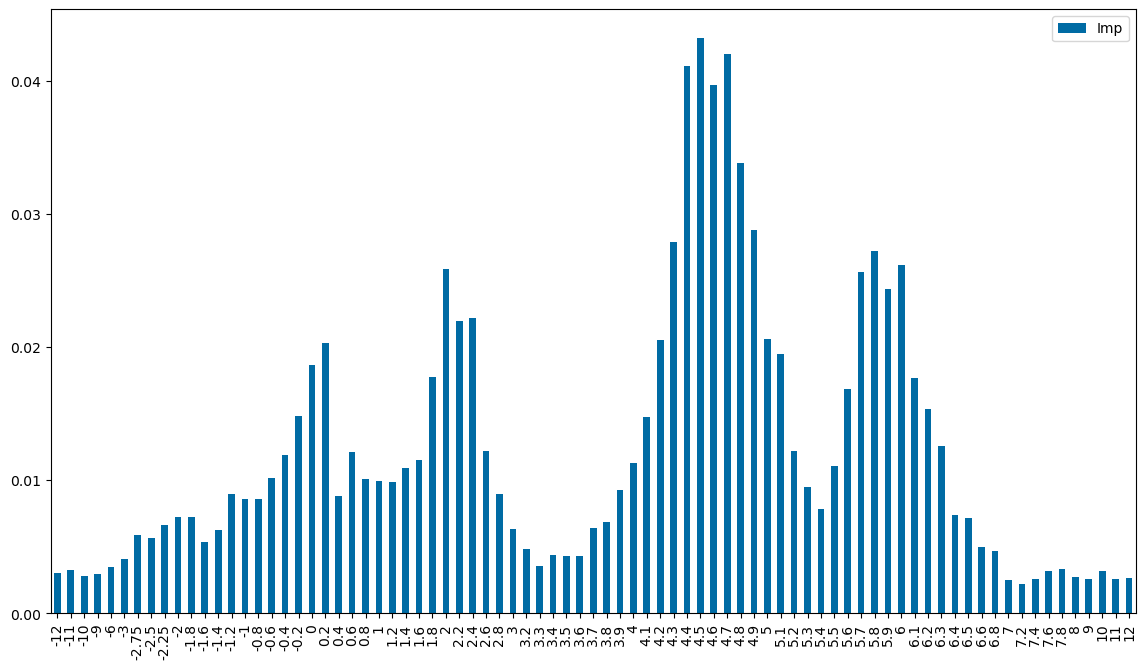

In [28]:
%%time

pH = 6.5

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_freqs65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_freqs65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.739
NPV : 0.911
SEN : 0.734
SPC : 0.913
------------------------------


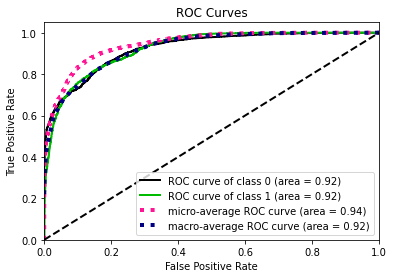

CPU times: user 5.1 s, sys: 140 ms, total: 5.24 s
Wall time: 49.4 s


<AxesSubplot:>

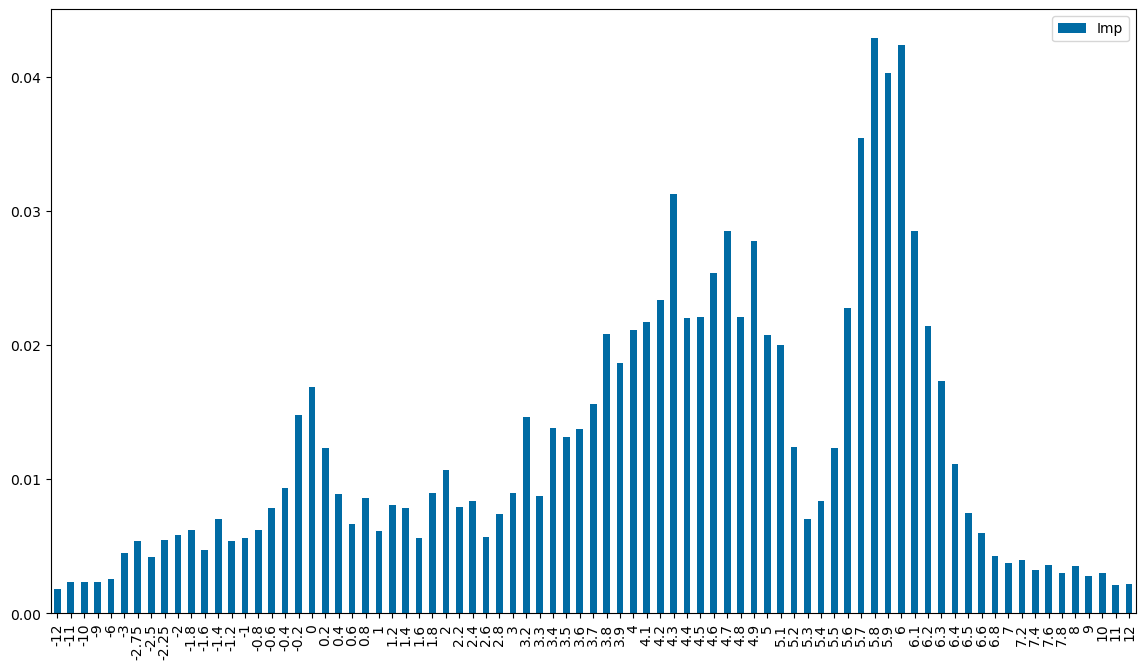

In [29]:
%%time

pH = 7.0

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_freqs70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_freqs70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

## -- All data

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.926
NPV : 0.898
SEN : 0.961
SPC : 0.82
------------------------------


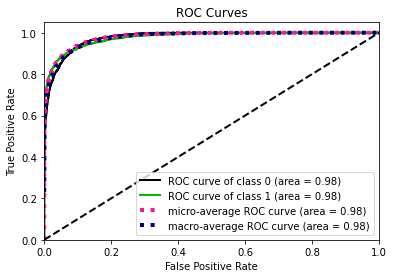

CPU times: user 16.5 s, sys: 186 ms, total: 16.7 s
Wall time: 50.3 s


<AxesSubplot:>

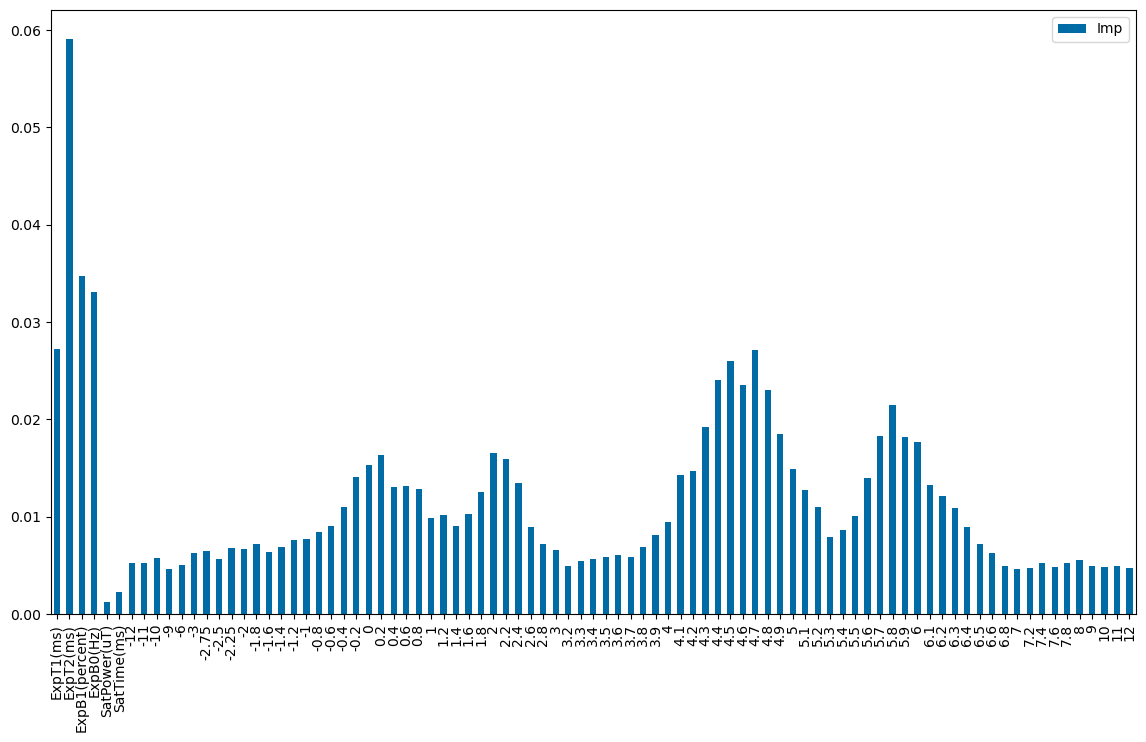

In [30]:
%%time


pH = 6.5

Xdata = acidoCEST_ML.drop(['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_data65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_data65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.78
NPV : 0.928
SEN : 0.783
SPC : 0.926
------------------------------


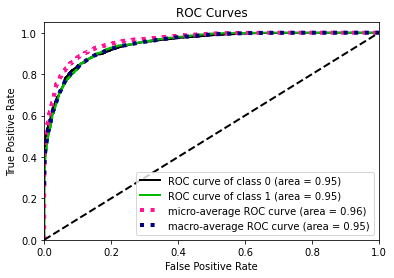

CPU times: user 6.54 s, sys: 144 ms, total: 6.69 s
Wall time: 47.7 s


<AxesSubplot:>

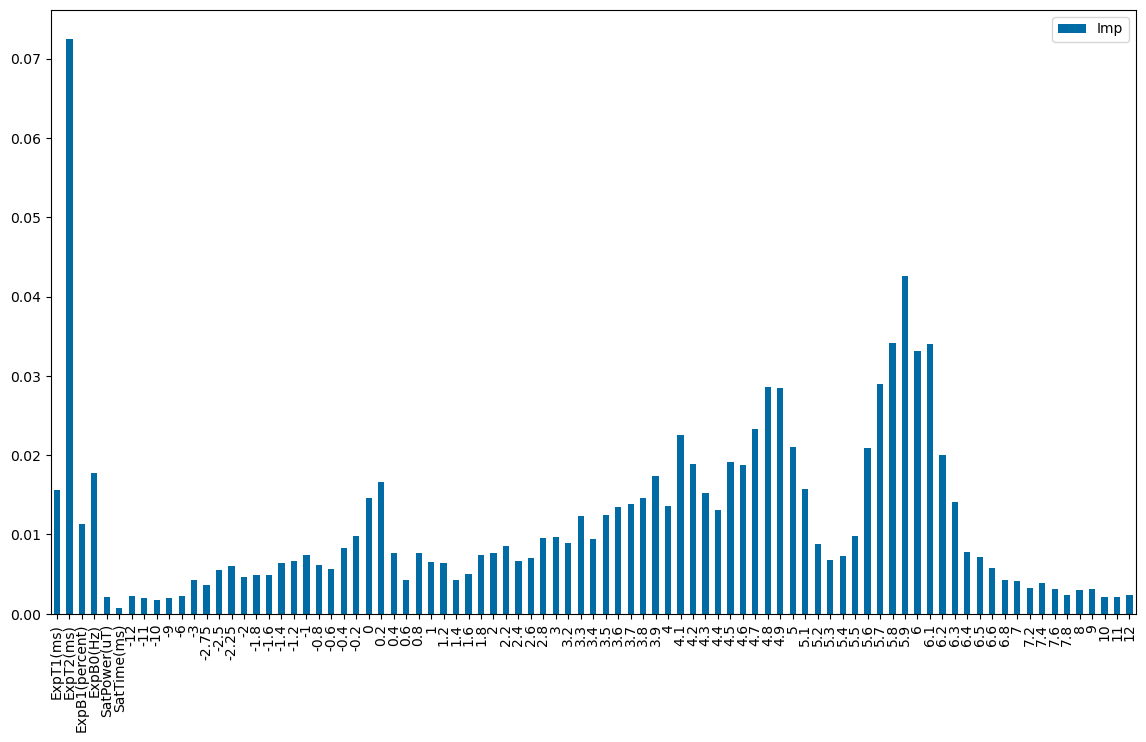

In [31]:
%%time

pH = 7.0

Xdata = acidoCEST_ML.drop(['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_data70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_data70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

## -- Selected features

In [32]:
s1 = set(pd.DataFrame(RF_all_data65.feature_importances_, index=Xdata.columns, columns=['Imp']).sort_values('Imp',ascending=False).head(20).index)
s2 = set(pd.DataFrame(RF_all_data70.feature_importances_, index=Xdata.columns, columns=['Imp']).sort_values('Imp',ascending=False).head(20).index)
sel_f = list(s1.union(s1))
sel_f.sort()
print(f'The following features were selected for Random Forest are : \n {sel_f}')

The following features were selected for Random Forest are : 
 ['0', '0.2', '2', '2.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.7', '5.8', '5.9', '6', 'ExpB0(Hz)', 'ExpB1(percent)', 'ExpT1(ms)', 'ExpT2(ms)']


In [33]:
len(sel_f)

20

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.966
NPV : 0.957
SEN : 0.982
SPC : 0.919
------------------------------


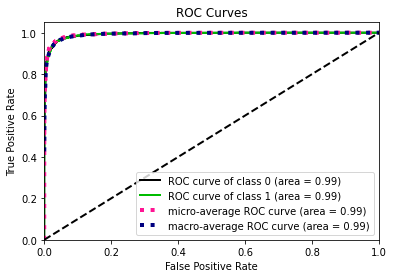

CPU times: user 7.48 s, sys: 166 ms, total: 7.64 s
Wall time: 22.9 s


<AxesSubplot:>

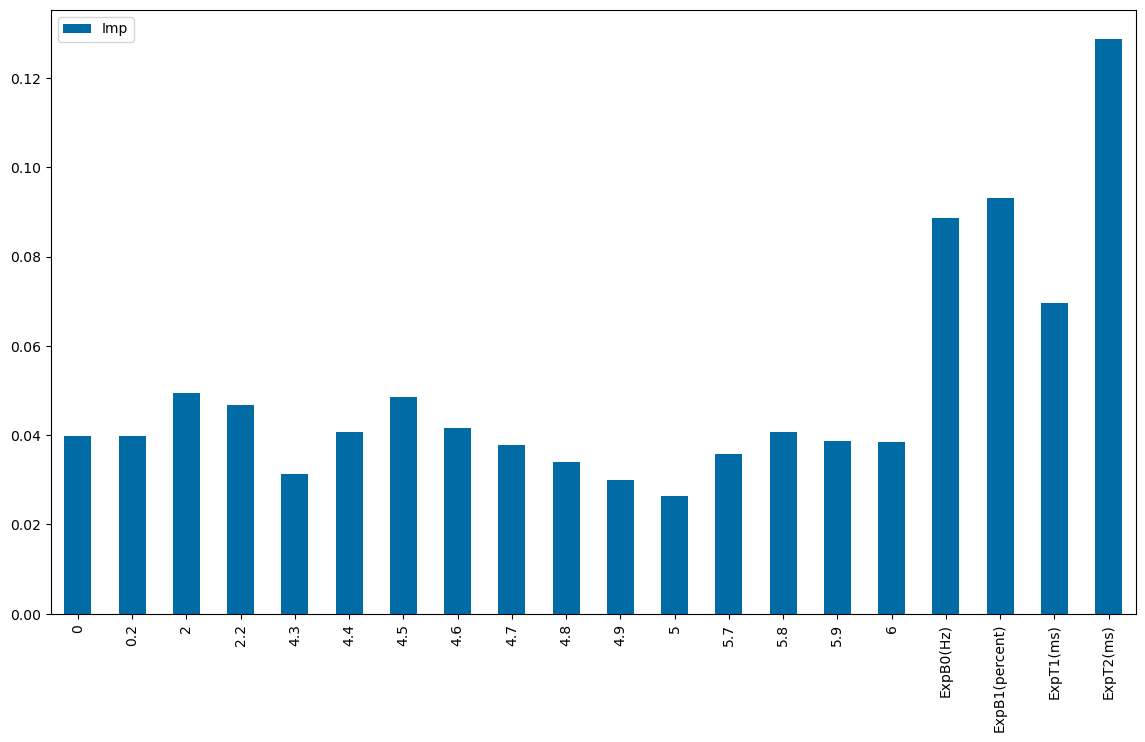

In [34]:
%%time

pH = 6.5

Xdata = acidoCEST_ML[sel_f]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.965
NPV : 0.947
SEN : 0.833
SPC : 0.99
------------------------------


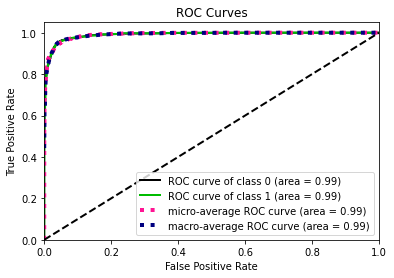

CPU times: user 7.61 s, sys: 174 ms, total: 7.79 s
Wall time: 23.3 s


<AxesSubplot:>

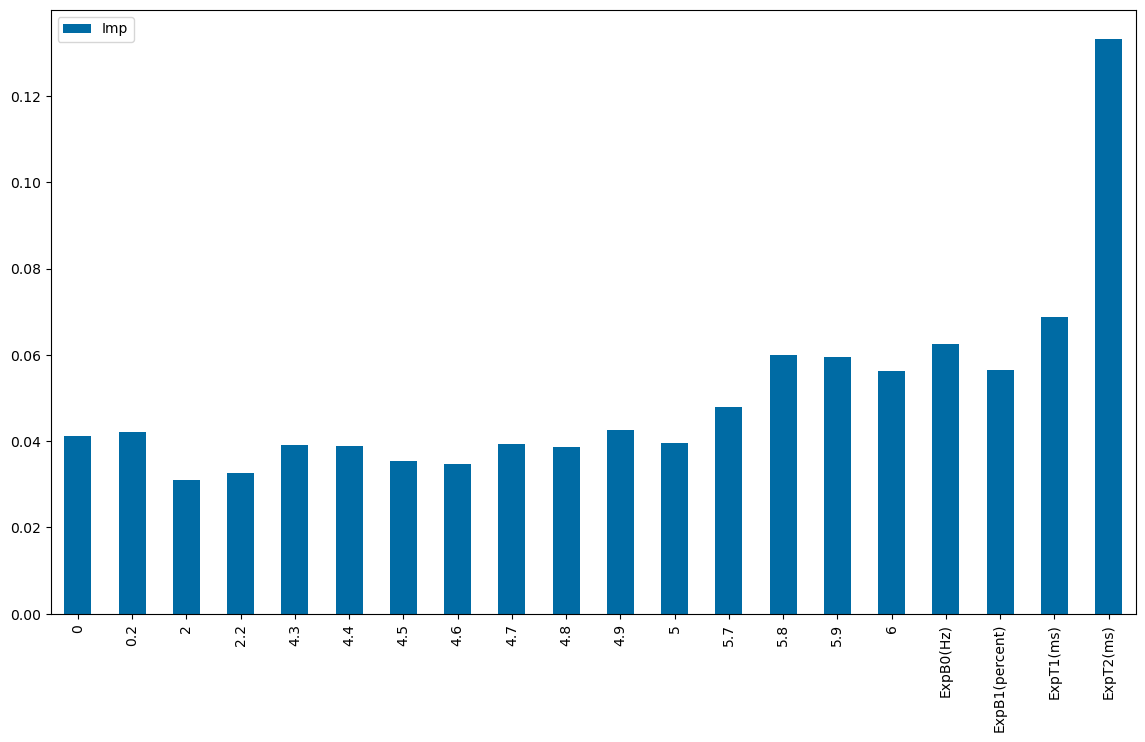

In [35]:
%%time

pH = 7.0

Xdata = acidoCEST_ML[sel_f]
Ydata = acidoCEST_ML.pH 

RF_set_features_70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

In [36]:
# save models for RF
# clf = load('filename.joblib') 
# https://scikit-learn.org/stable/modules/model_persistence.html
dump( RF_set_features_65, '../models/pH_classication_random_forest_6p5.joblib') 
dump( RF_set_features_70, '../models/pH_classication_random_forest_7p0.joblib') 

['../models/pH_classication_random_forest_7p0.joblib']

## Tree Vis

In [37]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


new_names = []

for i,x in enumerate(sel_f):
    if x.split('.')[0].isnumeric() == True:
        new_names.append( f'{x} ppm' )
        
    else:
        new_names.append( x.split('(')[0].split('Exp')[1] )


        
        
tree=RF_set_features_70.estimators_[9]

classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = new_names, class_names= classes,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig('../figs/Tree_example_max_depth_04_tree09.png',bbox_inches='tight')

In [38]:
from  sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree, 
                 out_file='tree09_04_levels.dot', 
                feature_names = new_names,
                class_names = classes,
                max_depth = 4 ,
                rounded = True, proportion = False, 
                precision = 2, filled = True, leaves_parallel=True, rotate=True)

In [39]:
from sklearn.tree import export_text

tree_as_text_09 = export_text(RF_set_features_70.estimators_[9]
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = new_names 
                  , show_weights=True )   

print(tree_as_text_09)

|--- 4.3 ppm <= 0.864
|   |--- 6 ppm <= 0.906
|   |   |--- 4.4 ppm <= 0.736
|   |   |   |--- T2 <= 231.595
|   |   |   |   |--- 0 ppm <= 0.169
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- 0 ppm >  0.169
|   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- T2 >  231.595
|   |   |   |   |--- 6 ppm <= 0.671
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- 6 ppm >  0.671
|   |   |   |   |   |--- truncated branch of depth 12
|   |   |--- 4.4 ppm >  0.736
|   |   |   |--- B0 <= 113.255
|   |   |   |   |--- 5.9 ppm <= 0.837
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- 5.9 ppm >  0.837
|   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- B0 >  113.255
|   |   |   |   |--- 2 ppm <= 0.361
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- 2 ppm >  0.361
|   |   |   |   |   |--- truncated branch of depth 14
|   |--- 6 ppm >  0.906
|   |   |--- 4.7 ppm <= 0.9

## -- Selected features (withou B1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.944
NPV : 0.9
SEN : 0.959
SPC : 0.866
------------------------------


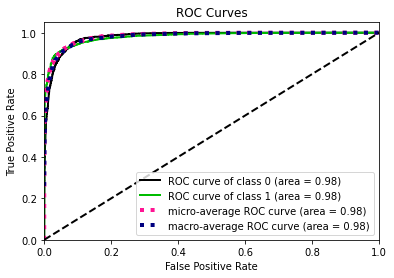

CPU times: user 7.74 s, sys: 164 ms, total: 7.9 s
Wall time: 23.9 s


<AxesSubplot:>

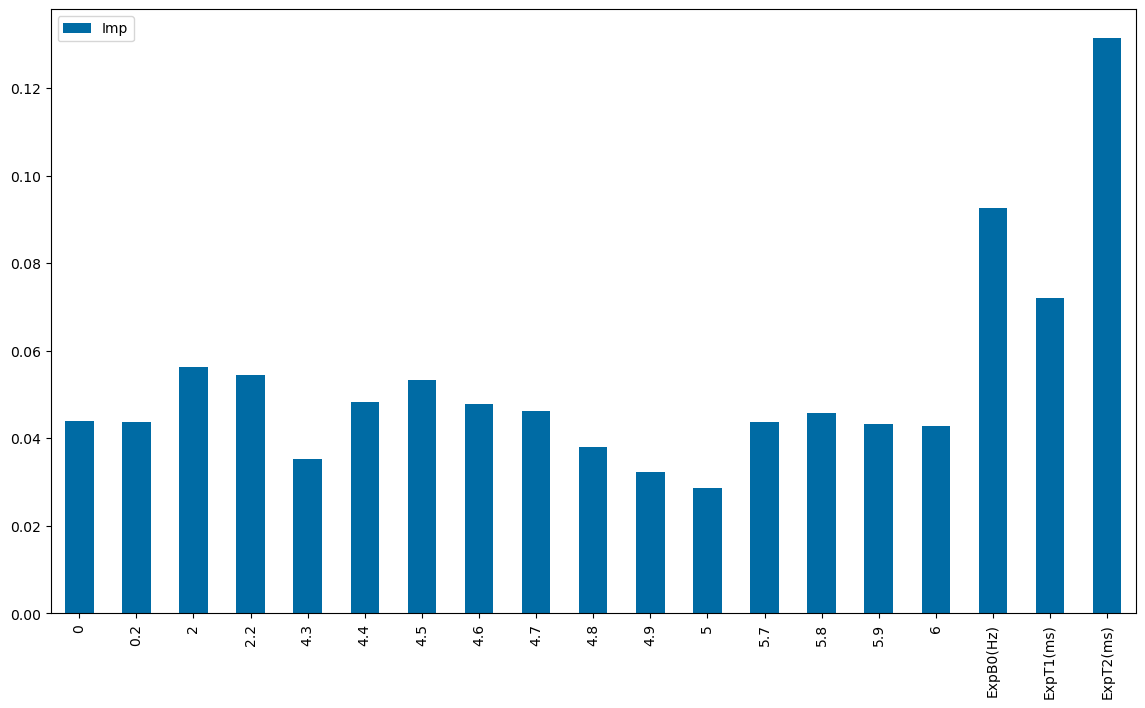

In [40]:
%%time

pH = 6.5
preds = [x for x in sel_f  if 'B1' not in x ]

Xdata = acidoCEST_ML[preds]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.955
NPV : 0.932
SEN : 0.785
SPC : 0.988
------------------------------


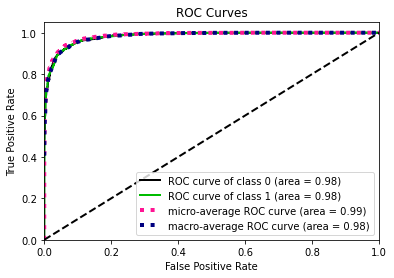

CPU times: user 7.13 s, sys: 156 ms, total: 7.28 s
Wall time: 23.6 s


<AxesSubplot:>

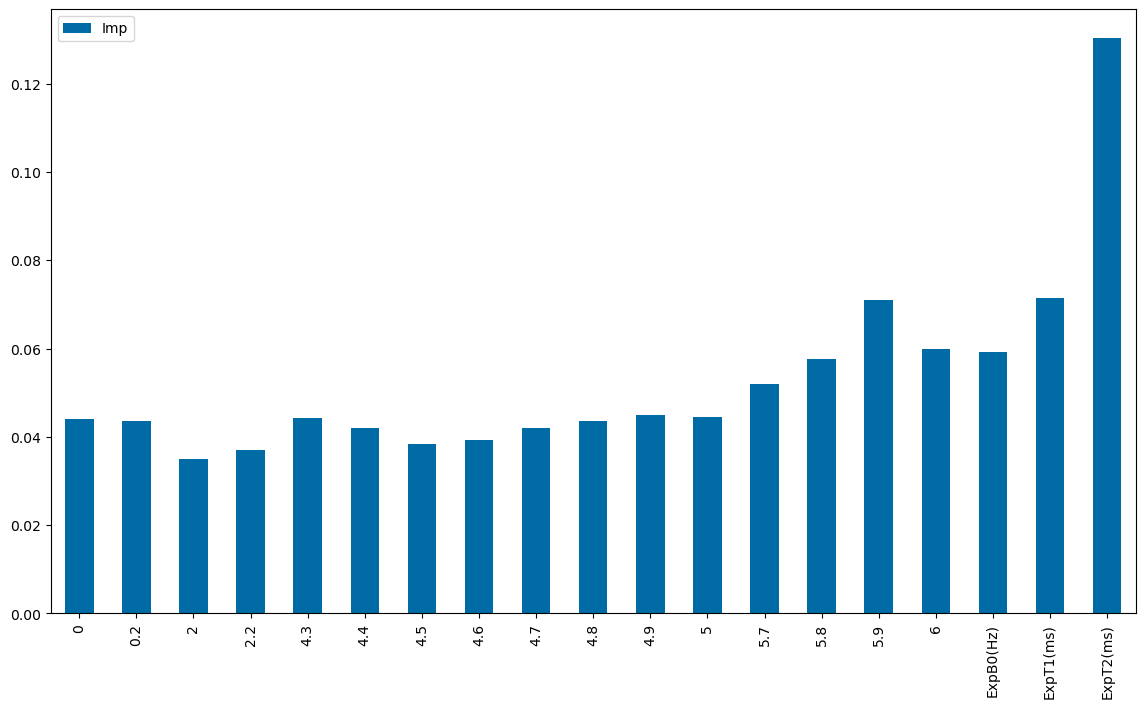

In [41]:
%%time

pH = 7.
preds = [x for x in sel_f  if 'B1' not in x ]

Xdata = acidoCEST_ML[preds]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)